In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer, ConvolutionalLayer, MaxPoolingLayer, Flattener
from model import ConvNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

In [3]:
def prepare_for_neural_network(train_X, test_X):    
    train_X = train_X.astype(np.float) / 255.0
    test_X = test_X.astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_X, axis = 0)
    train_X -= mean_image
    test_X -= mean_image
    
    return train_X, test_X
    
train_X, train_y, test_X, test_y = load_svhn("../data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

In [678]:
# TODO: Implement ConvolutionaLayer that supports only 1 output and input channel

# Note: now you're working with images, so X is 4-dimensional tensor of
# (batch_size, height, width, channels)

X = np.array([
              [
               [[1.0], [2.0]],
               [[0.0], [-1.0]]
              ]
              ,
              [
               [[0.0], [1.0]],
               [[-2.0], [-1.0]]
              ]
             ])

# Batch of 2 images of dimensions 2x2 with a single channel
print("Shape of X:",X.shape)

layer = ConvolutionalLayer(in_channels=1, out_channels=1, filter_size=2, padding=0)
print("Shape of W", layer.W.value.shape)
layer.W.value = np.zeros_like(layer.W.value)
layer.W.value[0, 0, 0, 0] = 1.0
layer.B.value = np.ones_like(layer.B.value)
result = layer.forward(X)

assert result.shape == (2, 1, 1, 1)
assert np.all(result == X[:, :1, :1, :1] +1), "result: %s, X: %s" % (result, X[:, :1, :1, :1])


# Now let's implement multiple output channels
layer = ConvolutionalLayer(in_channels=1, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 1, 1, 2)


# And now multple input channels!
X = np.array([
              [
               [[1.0, 0.0], [2.0, 1.0]],
               [[0.0, -1.0], [-1.0, -2.0]]
              ]
              ,
              [
               [[0.0, 1.0], [1.0, -1.0]],
               [[-2.0, 2.0], [-1.0, 0.0]]
              ]
             ])

print("Shape of X:", X.shape)
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 1, 1, 2)

Shape of X: (2, 2, 2, 1)
Shape of W (2, 2, 1, 1)
Shape of X: (2, 2, 2, 2)


In [679]:
# # First test - check the shape is right
# layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
# result = layer.forward(X)
# d_input = layer.backward(np.ones_like(result))
# assert d_input.shape == X.shape

# Actually test the backward pass
# As usual, you'll need to copy gradient check code from the previous assignment
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_gradient(layer, X)

layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_param_gradient(layer, X, 'W')
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_param_gradient(layer, X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


In [680]:
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=3, padding=1)
result = layer.forward(X)
# Note this kind of layer produces the same dimensions as input
assert result.shape == X.shape,"Result shape: %s - Expected shape %s" % (result.shape, X.shape)
d_input = layer.backward(np.ones_like(result))
#print(d_input.shape)
#print(X.shape)
assert d_input.shape == X.shape
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=3, padding=1)
assert check_layer_gradient(layer, X)

Gradient check passed!


In [684]:
pool = MaxPoolingLayer(2, 2)
result = pool.forward(X)
assert result.shape == (2, 1, 1, 2)

assert check_layer_gradient(pool, X)

Gradient check passed!


In [685]:
flattener = Flattener()
result = flattener.forward(X)
assert result.shape == (2,8)

assert check_layer_gradient(flattener, X)

Gradient check passed!


In [693]:
# TODO: In model.py, implement missed functions function for ConvNet model

# No need to use L2 regularization
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=2, conv2_channels=2)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 3_W
Gradient check passed!
Checking gradient for 3_B
Gradient check passed!
Checking gradient for 7_W
Gradient check passed!
Checking gradient for 7_B
Gradient check passed!


True

In [765]:
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=2, conv2_channels=2)
dataset = Dataset(train_X[:16], train_y[:16], val_X[:16], val_y[:16])
trainer = Trainer(model, dataset, SGD(), batch_size=16, learning_rate=1e-4)

loss_history, train_history, val_history = trainer.fit()

Epoch 0, Loss: 2.302186, Train accuracy: 0.187500, val accuracy: 0.062500
Epoch 1, Loss: 2.302128, Train accuracy: 0.187500, val accuracy: 0.062500
Epoch 2, Loss: 2.302070, Train accuracy: 0.187500, val accuracy: 0.062500
Epoch 3, Loss: 2.302012, Train accuracy: 0.187500, val accuracy: 0.062500
Epoch 4, Loss: 2.301954, Train accuracy: 0.187500, val accuracy: 0.062500
Epoch 5, Loss: 2.301897, Train accuracy: 0.187500, val accuracy: 0.062500
Epoch 6, Loss: 2.301839, Train accuracy: 0.187500, val accuracy: 0.062500
Epoch 7, Loss: 2.301781, Train accuracy: 0.187500, val accuracy: 0.062500
Epoch 8, Loss: 2.301723, Train accuracy: 0.187500, val accuracy: 0.062500
Epoch 9, Loss: 2.301665, Train accuracy: 0.187500, val accuracy: 0.062500
Epoch 10, Loss: 2.301607, Train accuracy: 0.187500, val accuracy: 0.062500
Epoch 11, Loss: 2.301549, Train accuracy: 0.187500, val accuracy: 0.062500
Epoch 12, Loss: 2.301491, Train accuracy: 0.187500, val accuracy: 0.062500
Epoch 13, Loss: 2.301434, Train acc

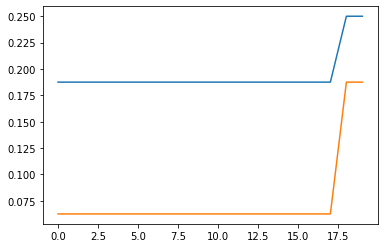

In [766]:
plt.plot(train_history)
plt.plot(val_history)

In [870]:
data_size = 128
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=30, conv2_channels=30)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach 1.0 training accuracy in 50 epochs or less
# Hint: If you have hard time finding the right parameters manually, try grid search or random search!
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-3, num_epochs=50, batch_size=16)

loss_history, train_history, val_history = trainer.fit()

Epoch 0, Loss: 95.301511, Train accuracy: 0.093750, val accuracy: 0.070312
Epoch 1, Loss: 34.962548, Train accuracy: 0.117188, val accuracy: 0.148438
Epoch 2, Loss: 36.109892, Train accuracy: 0.265625, val accuracy: 0.195312
Epoch 3, Loss: 6.442807, Train accuracy: 0.273438, val accuracy: 0.203125
Epoch 4, Loss: 5.712744, Train accuracy: 0.281250, val accuracy: 0.117188
Epoch 5, Loss: 3.551810, Train accuracy: 0.343750, val accuracy: 0.171875
Epoch 6, Loss: 4.250929, Train accuracy: 0.445312, val accuracy: 0.109375
Epoch 7, Loss: 2.175061, Train accuracy: 0.492188, val accuracy: 0.140625
Epoch 8, Loss: 1.059867, Train accuracy: 0.617188, val accuracy: 0.101562
Epoch 9, Loss: 1.459723, Train accuracy: 0.671875, val accuracy: 0.125000
Epoch 10, Loss: 1.238465, Train accuracy: 0.750000, val accuracy: 0.117188
Epoch 11, Loss: 0.559460, Train accuracy: 0.765625, val accuracy: 0.125000
Epoch 12, Loss: 0.817769, Train accuracy: 0.781250, val accuracy: 0.101562
Epoch 13, Loss: 0.986250, Train 

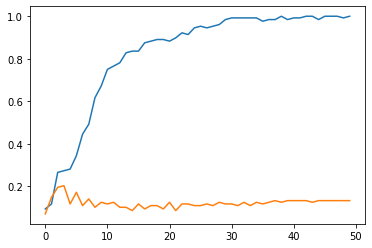

In [871]:
plt.plot(train_history)
plt.plot(val_history)